In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [23]:
def get_table_for_topic_evolution(topic_id, no_topwords=10):
    tterms = []
    topic = Topic.objects.get(id=topic_id)
    tts = TopicTerm.objects.filter(topic=topic)
    tdts = TopicTimePeriodScores.objects.filter(
        topic=topic
    ).order_by('period__n')
    for i, p in enumerate(stat.periods.all().order_by('n')):
        ytts = tts.filter(
            PY=p.n
        ).order_by('-score')[:no_topwords].select_related('term')
        top_terms = [topicterm.term.title for topicterm in ytts]
        #tdt = tdts[i]
        try:
            tdt = tdts.get(period=p)
            tdt.share = tdt.share*100
        except:
            print("failed to retrieve share")
            tdt = None
        tterms_dict = {#"score": tdt.score,
            "share": tdt.share,
            "period": p.parlperiod.n}
        for j, term in enumerate(top_terms):
            tterms_dict[j+1] = term
        tterms.append(tterms_dict)

    df = pd.DataFrame(data=tterms).set_index('period')
    df = df.transpose()

    return df

In [31]:
import matplotlib.patches as patches

def plot_topword_evolution_table(df, filename="", no_topwords=10):
    sns.set()
    sns.set_context('paper')
    fig, ax = plt.subplots(figsize = (len(df.columns)*1.3, no_topwords * 0.3))

    # build color dict:
    topword_list = [i for i in df.drop("share").values]
    topword_set = set(np.array(topword_list).flatten())

    #palette = sns.color_palette('husl', len(topword_set))
    palette = sns.color_palette("tab10", n_colors=len(topword_set), desat=0.8)
    #palette = sns.color_palette('dark', n_colors=len(topword_set))
    palette[10] = (0, 0, 0)

    # cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
    color_dict = {topword: palette[i] for i, topword in enumerate(topword_set)}
    #sns.palplot(palette)

    for i, column in enumerate(df.columns):
        share = df[column]["share"]
        ax.text(i + 0.5, no_topwords + 1.2, column, weight='bold', horizontalalignment='center')
        ax.text(i + 0.5, no_topwords + 0.2, "({0:.2f}%)".format(share), horizontalalignment='center')

        for j, word in enumerate(df[column]):
            if isinstance(word, float):
                pass
            else:
                ax.text(i+0.5, no_topwords - j, word, horizontalalignment='center', color=color_dict[word])

        p = patches.Rectangle(
            (i+0.05, -0.2), 0.9, no_topwords,
            fill=False, #transform=ax.transAxes,
            clip_on=False
            )
        ax.add_patch(p)

    ax.set_ylim([0, no_topwords + 2])
    ax.set_xlim([0, len(df.columns)])

    ax.axis('off')
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")

        
# plot word scores in the same colors
def plot_term_score_evolution(df, filename="", no_topwords=10):
    sns.set_context("talk")
    sns.set_style('whitegrid')

    terms = Term.objects.filter(topicterm__topic=topic).values('title').annotate(
    summed_score = Sum(F('topicterm__score'))).order_by('-summed_score')[:20]

    # build color dict:
    topword_list = [i for i in df.drop("share").values]
    topword_set = set(np.array(topword_list).flatten())
    topicterm_list = [t['title'] for t in terms if t['title'] in topword_set]
    palette = sns.color_palette("tab10", n_colors=len(topword_set), desat=0.8)
    palette[10] = (0, 0, 0)
    color_dict = {topword: palette[i] for i, topword in enumerate(topword_set)}

    sdf = pd.DataFrame(columns=df.columns, index=topicterm_list)

    for topicterm in topicterm_list:
        for i, p in enumerate(stat.periods.all().order_by('n')):
            try:
                score = TopicTerm.objects.get(topic=topic, PY=p.n, term__title=topicterm).score
            except TopicTerm.DoesNotExist:
                score = 0
            sdf[p.parlperiod.n][topicterm] = score

    sdf

    fig, ax = plt.subplots()

    for i in sdf.index:
        ax.plot(sdf.columns, sdf.loc[i], label=i, color=color_dict[i])

        # for smoothing
        #from scipy.ndimage.filters import gaussian_filter1d
        #ysmoothed = gaussian_filter1d(y, sigma=2)
        #plt.plot(x, ysmoothed)
        #plt.show()

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Parliamentary period')
    plt.ylabel('term score')
    plt.title(topic.title)
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IndexError: list assignment index out of range

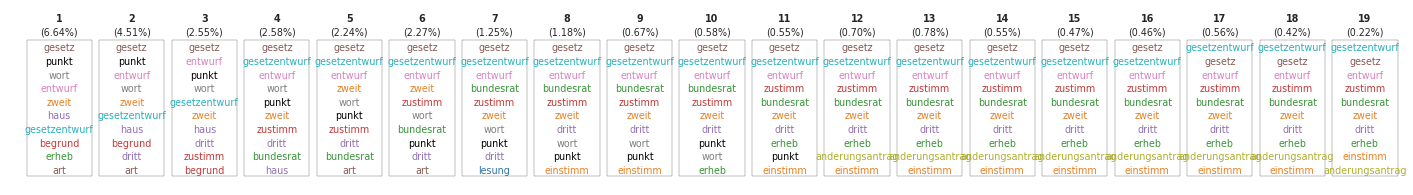

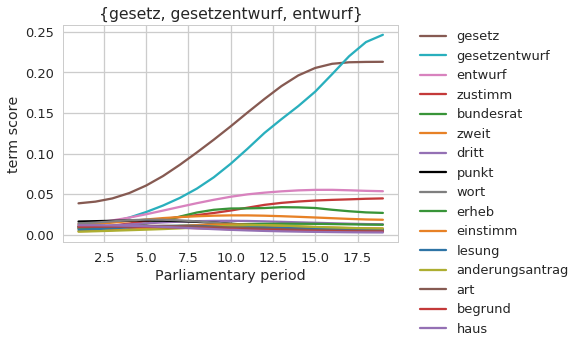

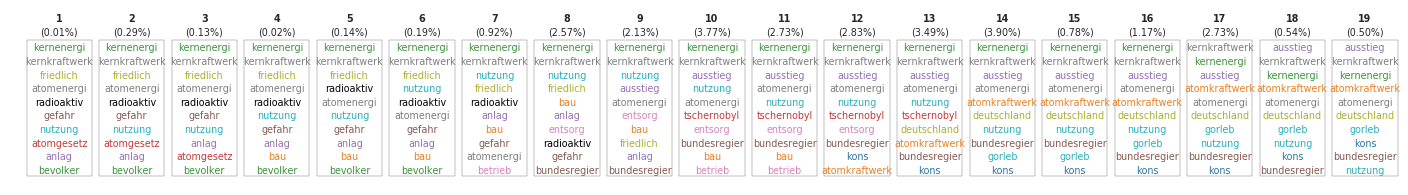

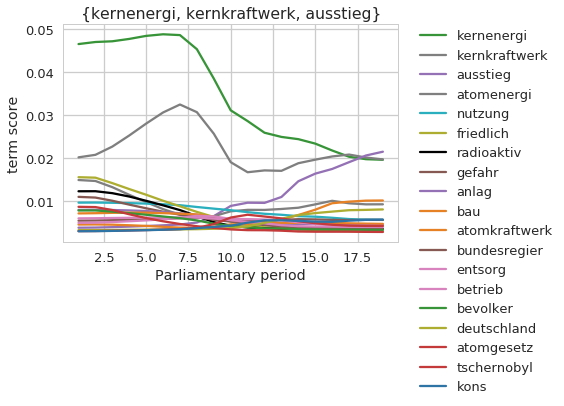

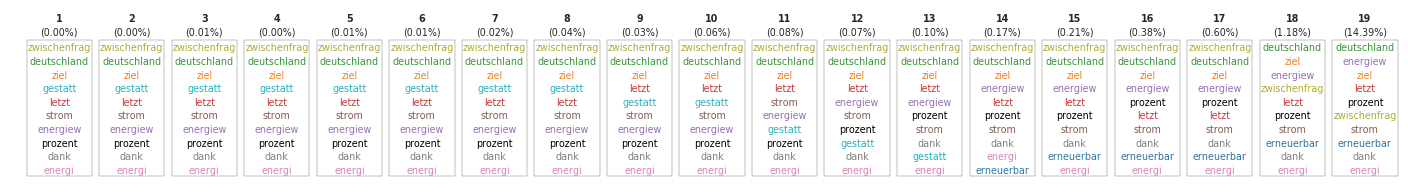

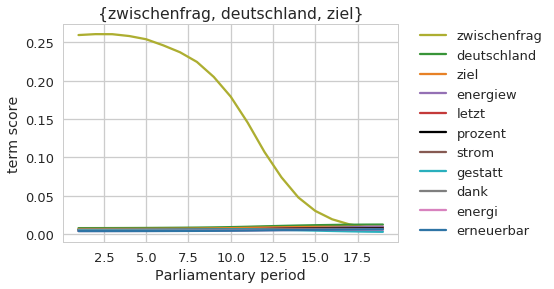

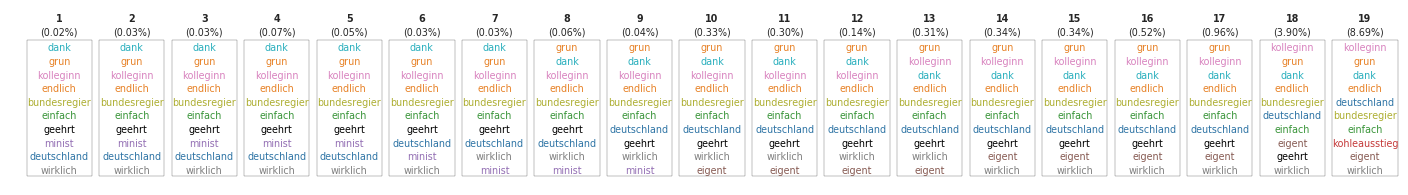

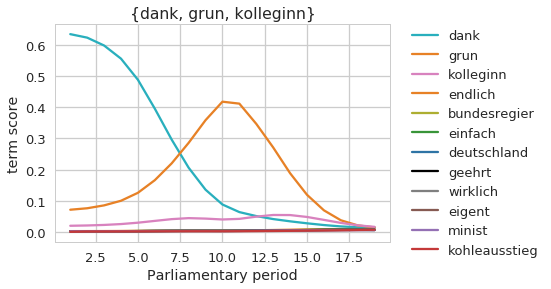

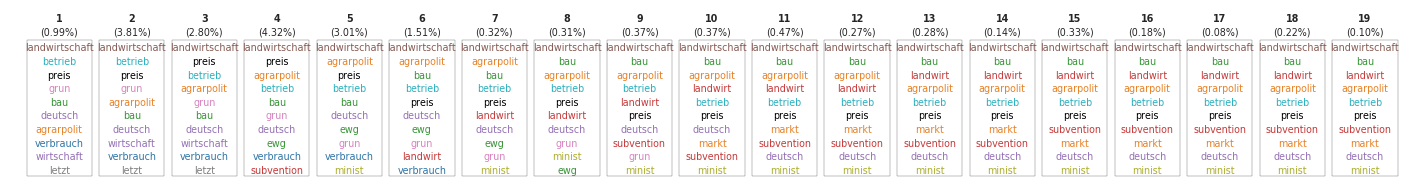

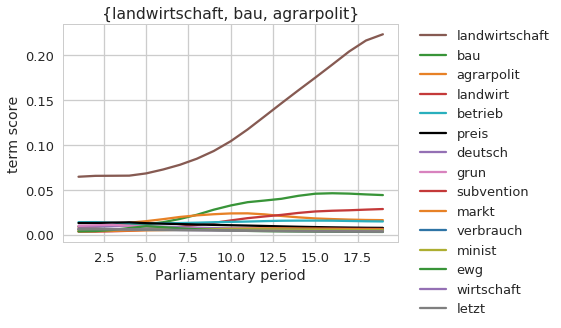

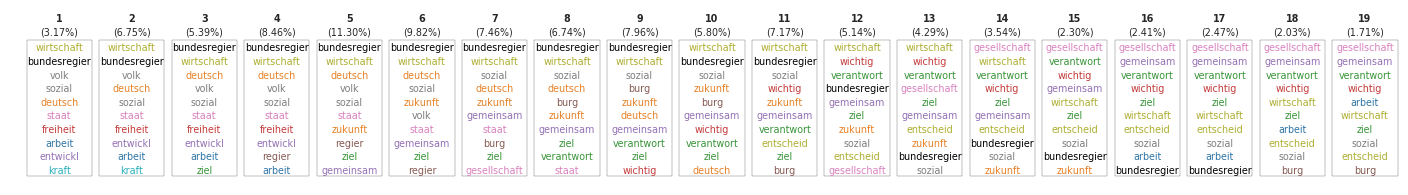

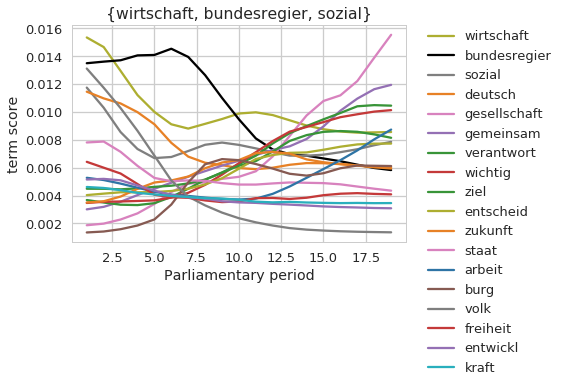

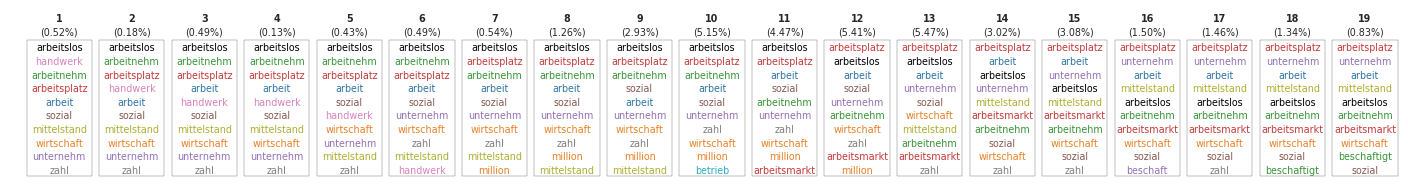

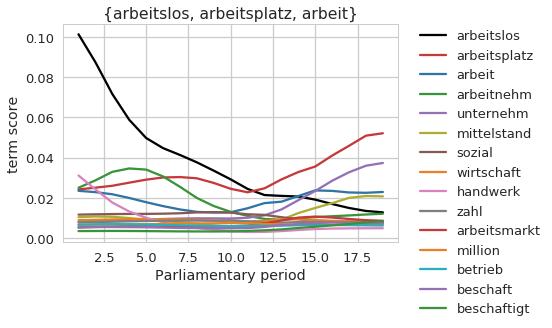

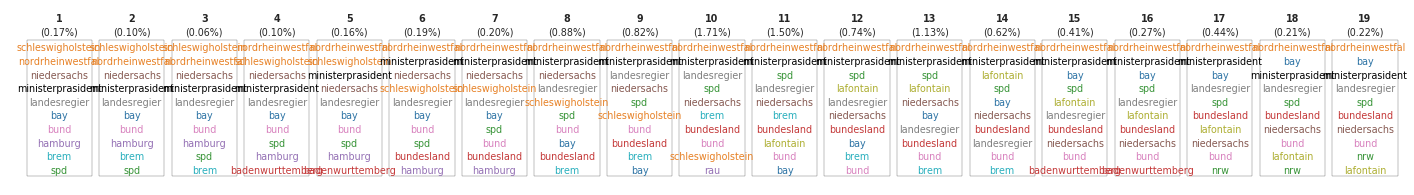

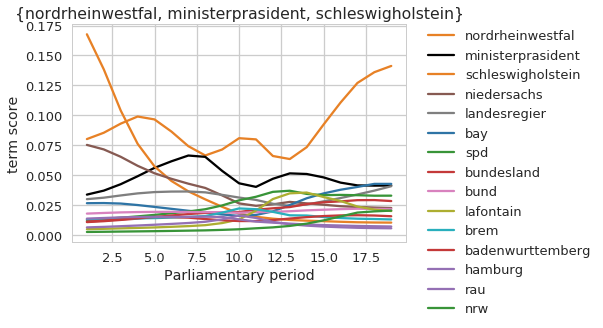

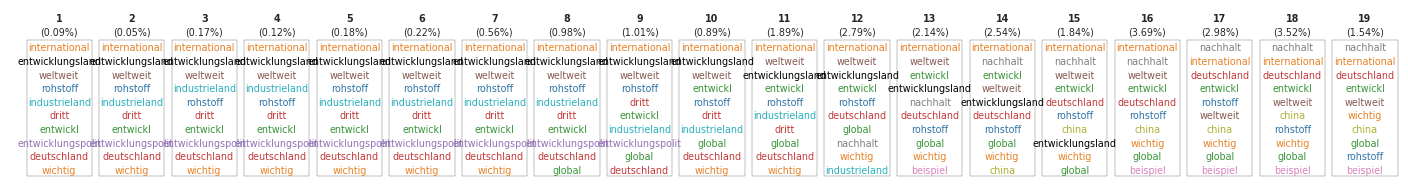

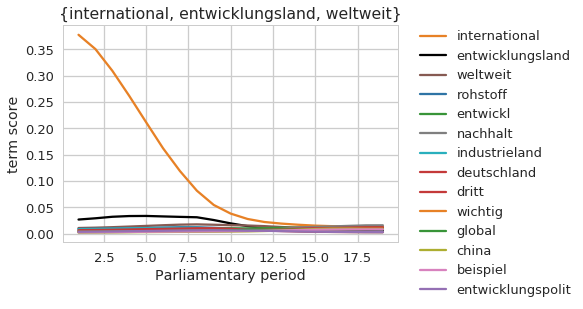

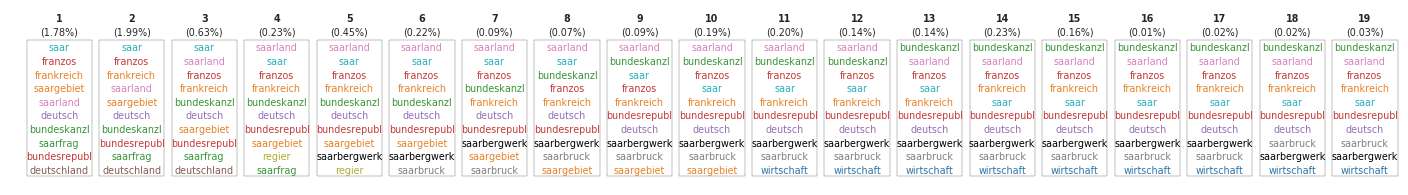

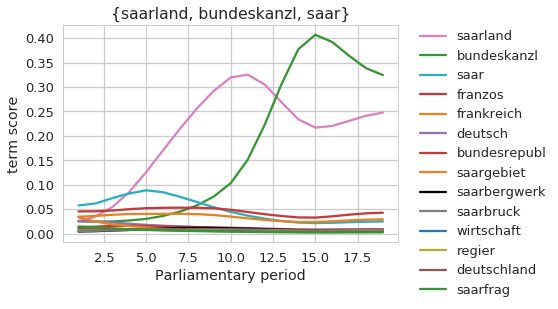

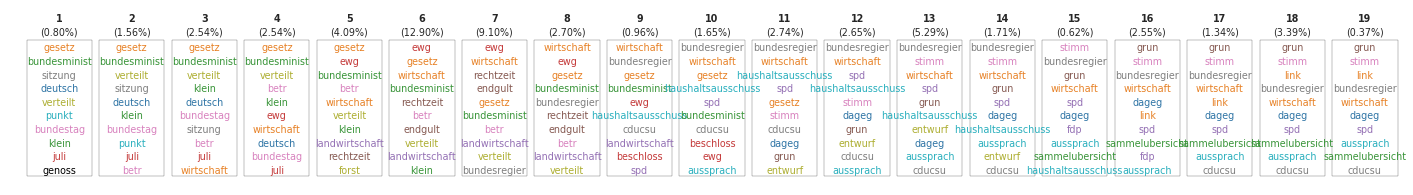

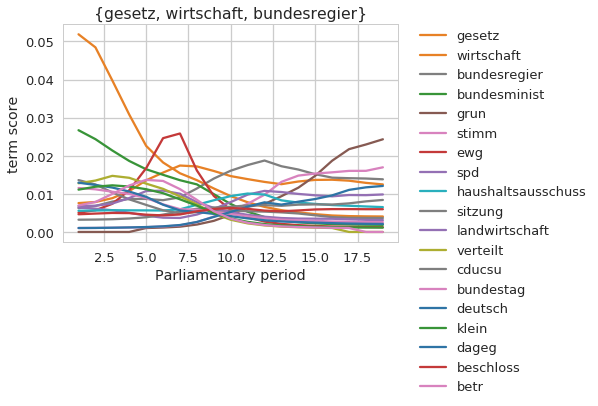

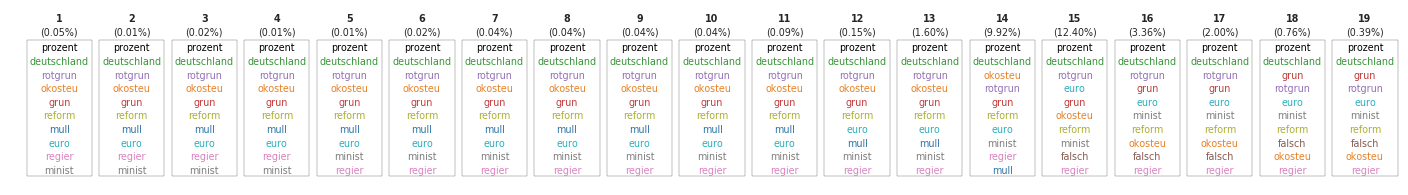

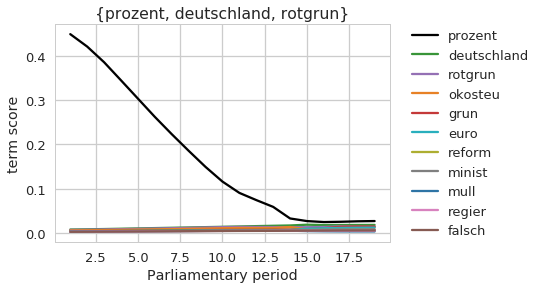

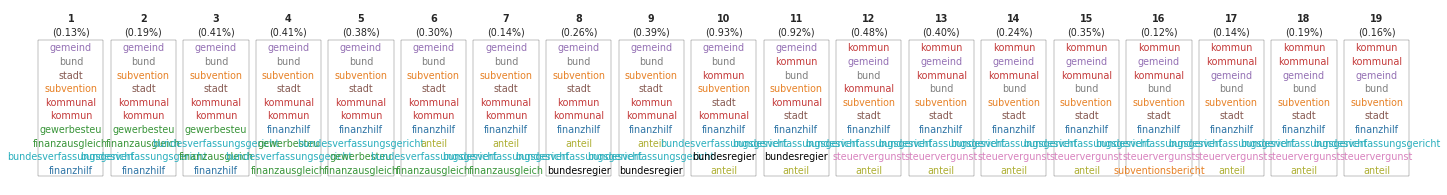

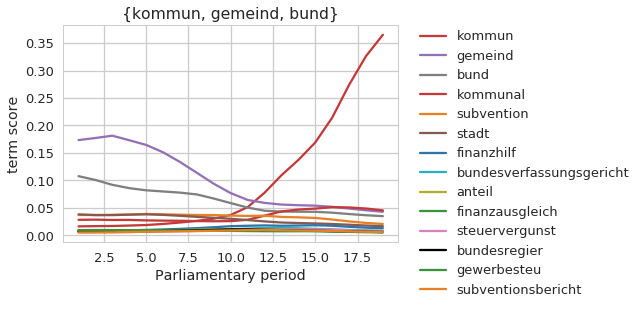

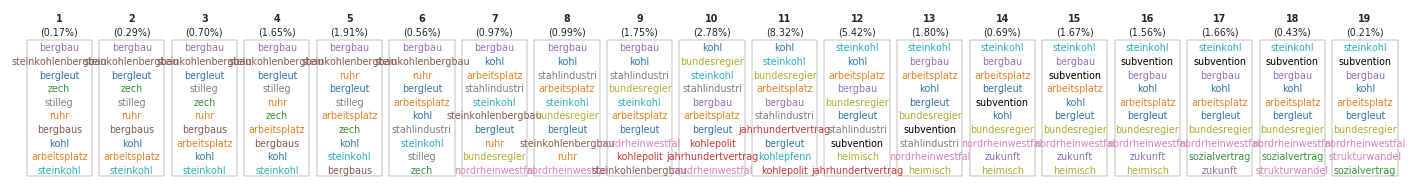

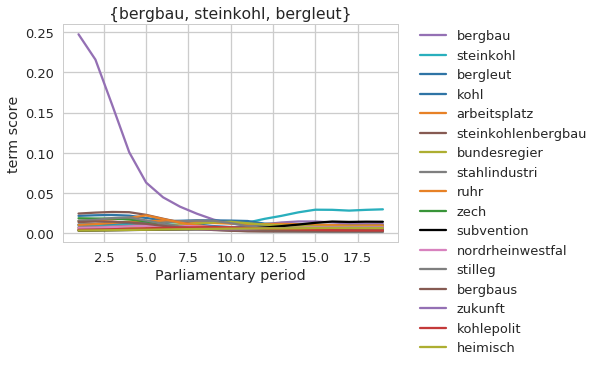

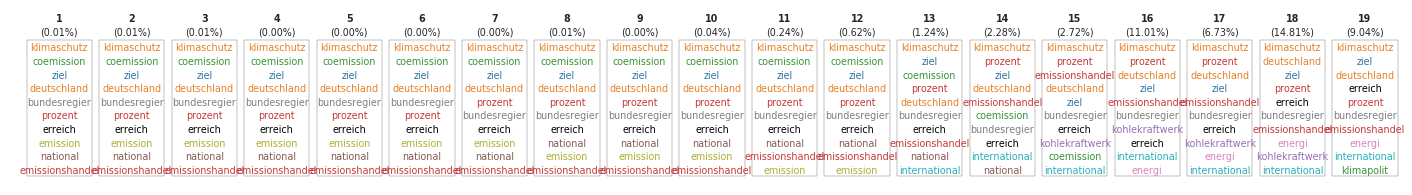

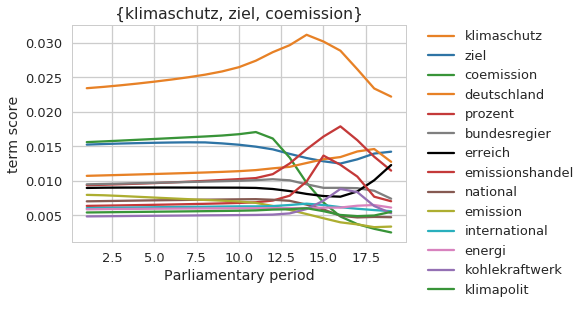

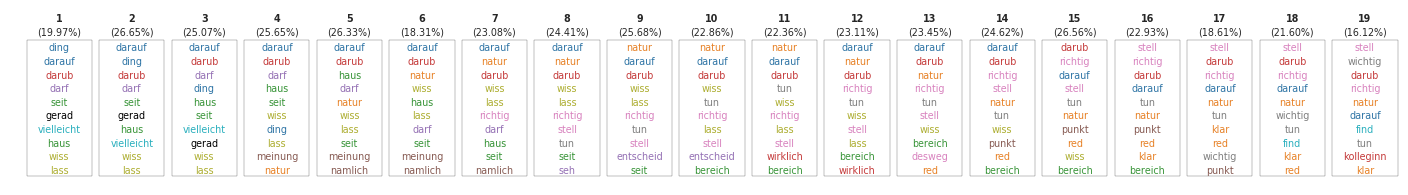

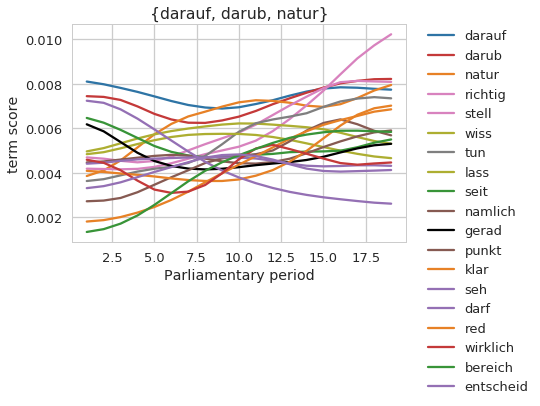

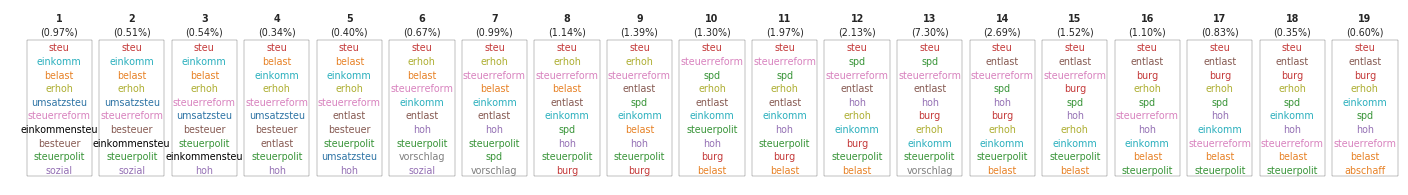

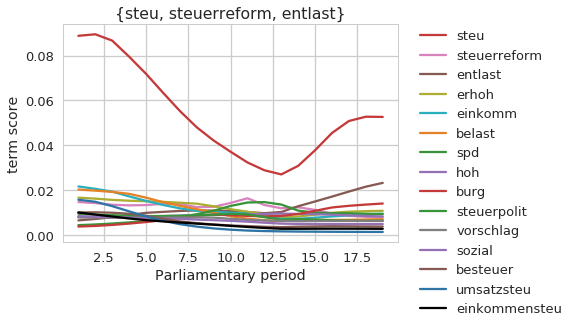

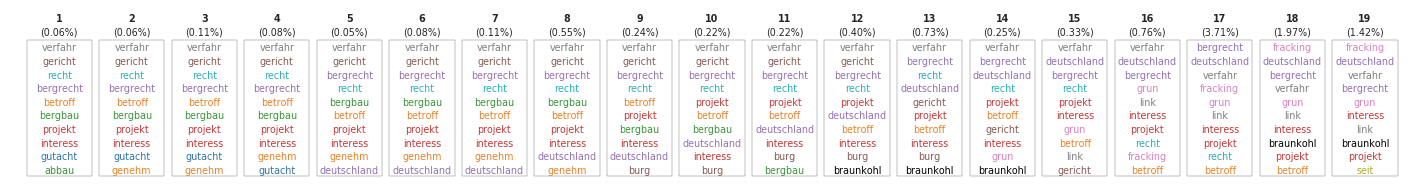

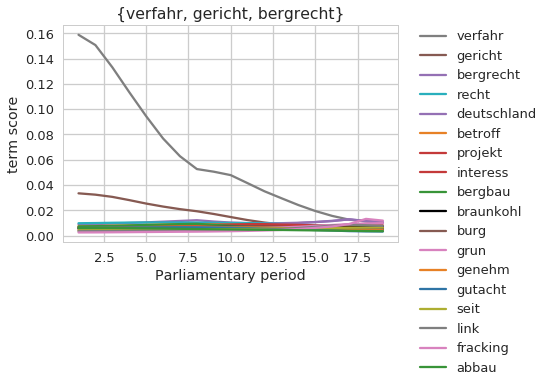

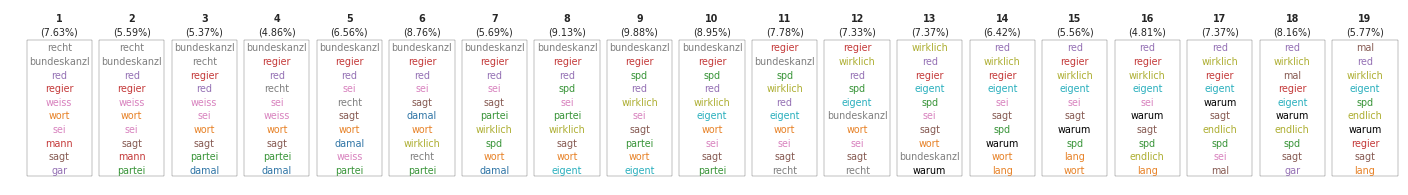

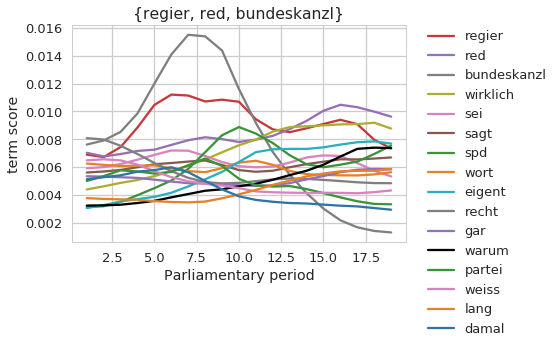

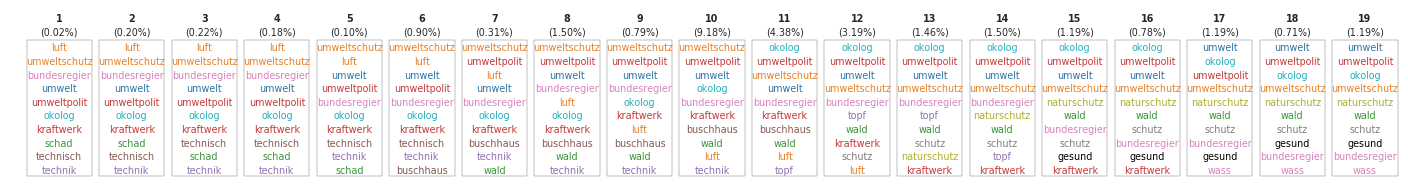

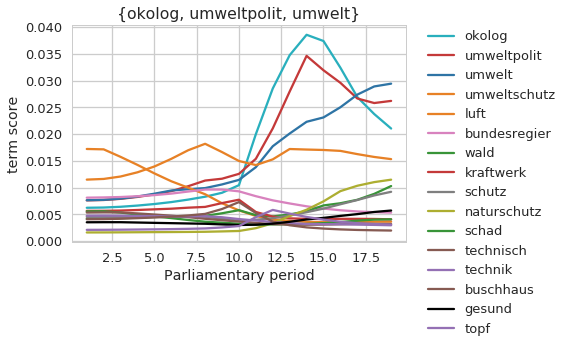

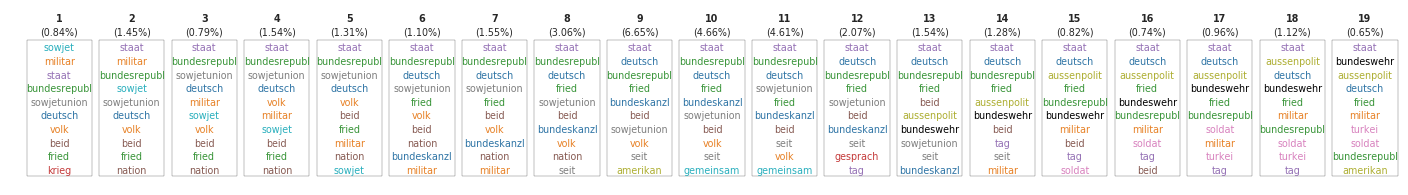

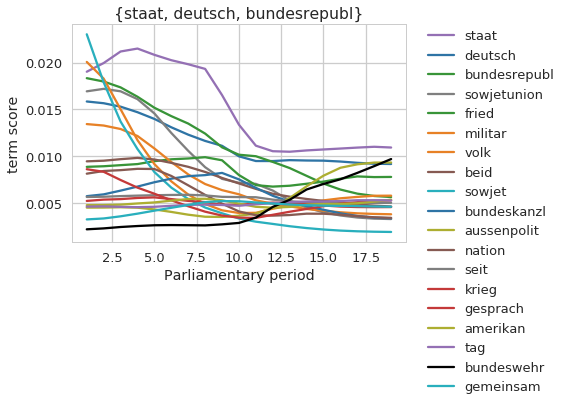

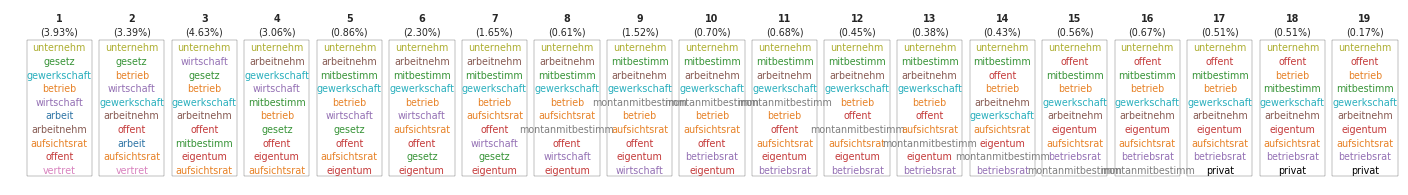

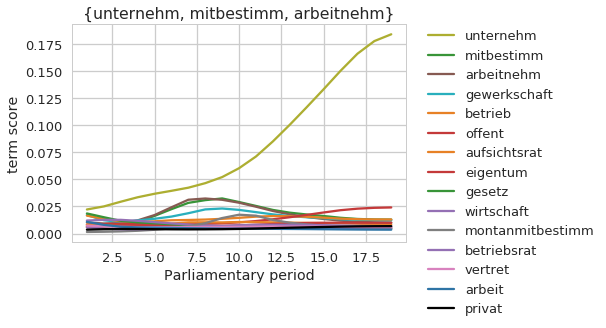

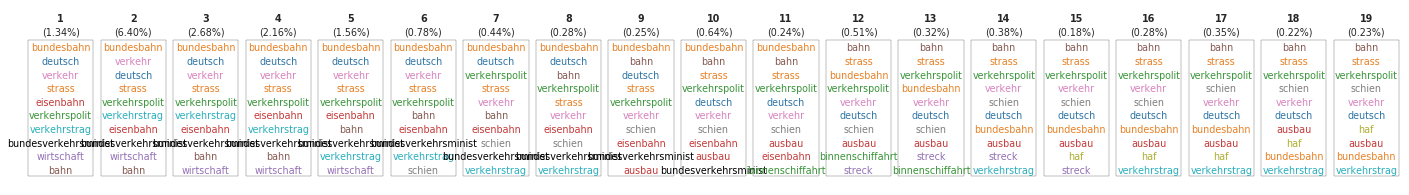

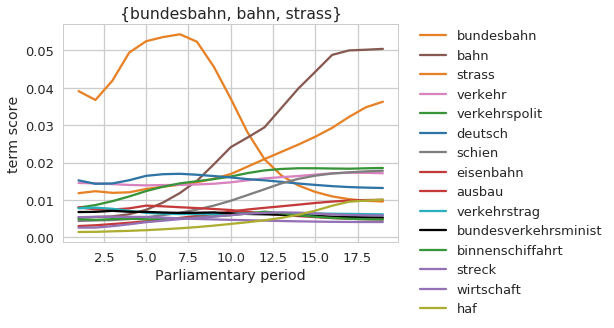

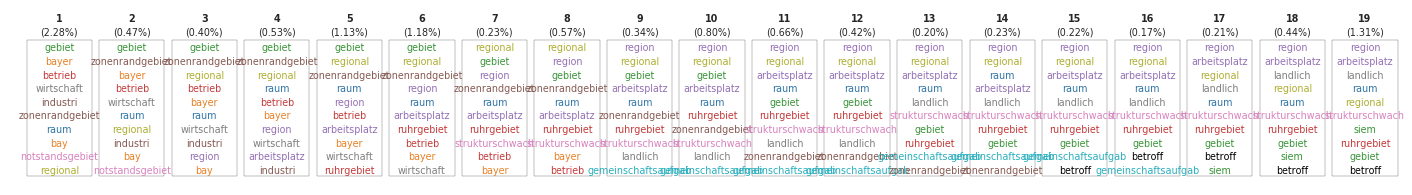

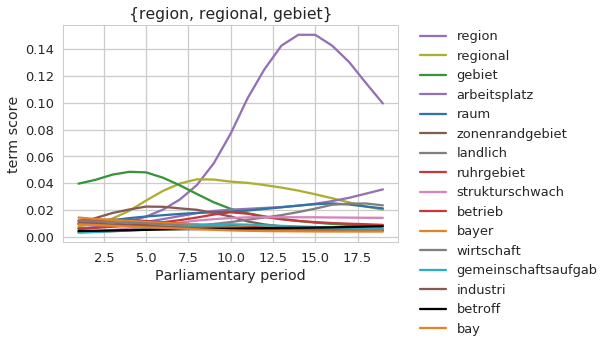

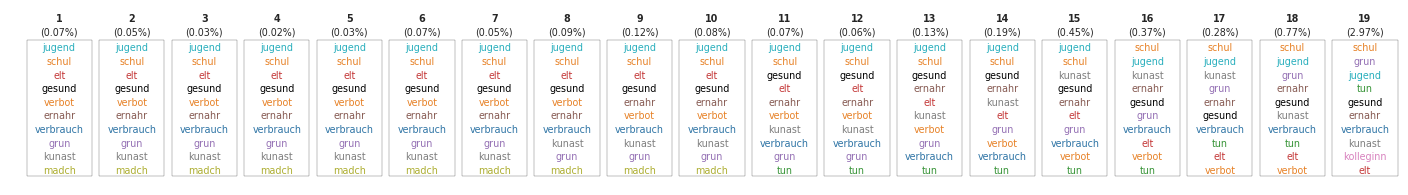

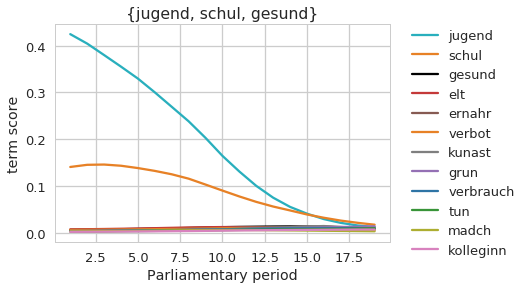

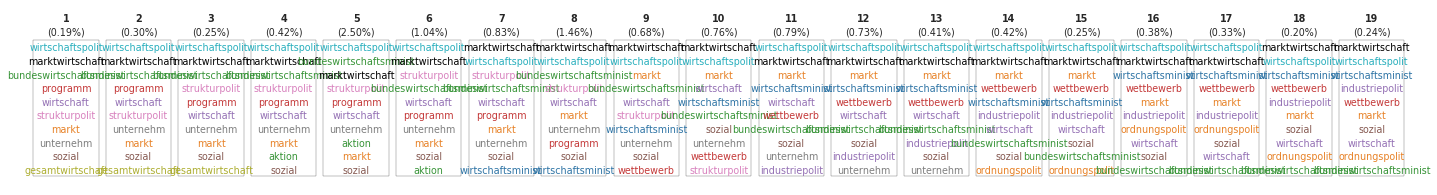

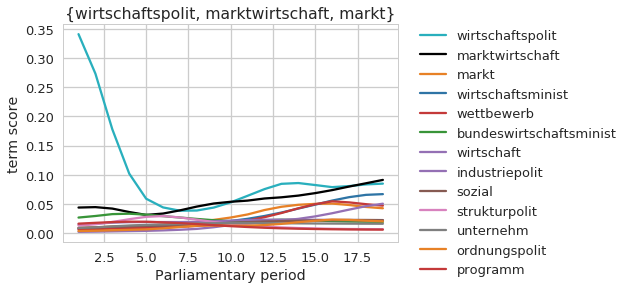

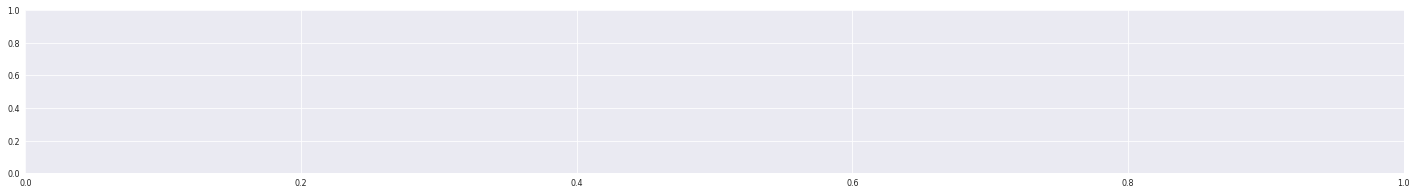

In [33]:
# for ISIE conference
topic_id = 167079
# topic_id = 167075 # energy transition 2
# topic_id = 167083 # energy transition
# topic_id = 167076 # economy and jobs
# topic_id = 167089 # climate policy
# topics = Topic.objects.filter(pk=topic_id)

run_id = 2111
topics = Topic.objects.filter(run_id=run_id)

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
for topic in topics:

    df = get_table_for_topic_evolution(topic.id)

    plot_topword_evolution_table(df, os.path.join(save_dir, 'topic_top_words_run_{}_topic_{}.png'.format(run_id, topic.id)))
    plot_term_score_evolution(df, os.path.join(save_dir, 'topic_term_scores_run_{}_topic_{}.png'.format(run_id, topic.id)))
    #df


# compress folder to easily download it

In [35]:
%%bash
zip -r plots/topic_analysis_2111.zip plots/topic_analysis_2111/

  adding: plots/topic_analysis_2111/ (stored 0%)
  adding: plots/topic_analysis_2111/topic_term_scores_run_2111_topic_177254.png (deflated 10%)
  adding: plots/topic_analysis_2111/party_shares_run_2111_topic_177261.png (deflated 25%)
  adding: plots/topic_analysis_2111/topic_top_words_run_2111_topic_177268.png (deflated 20%)
  adding: plots/topic_analysis_2111/party_proportions_run_2111_topic_177250.png (deflated 28%)
  adding: plots/topic_analysis_2111/party_shares_run_2111_topic_177272.png (deflated 23%)
  adding: plots/topic_analysis_2111/party_shares_run_2111_topic_177269.png (deflated 25%)
  adding: plots/topic_analysis_2111/topic_top_words_run_2111_topic_177273.png (deflated 9%)
  adding: plots/topic_analysis_2111/topic_term_scores_run_2111_topic_167079.png (deflated 10%)
  adding: plots/topic_analysis_2111/party_proportions_run_2111_topic_177237.png (deflated 28%)
  adding: plots/topic_analysis_2111/party_shares_run_2111_topic_177238.png (deflated 26%)
  adding: plots/topic_anal

{'score__sum': 3.58306462718893}
{'score__sum': 0.510003611552585}
{'score__count': 221}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff43ce87128>]],
      dtype=object)

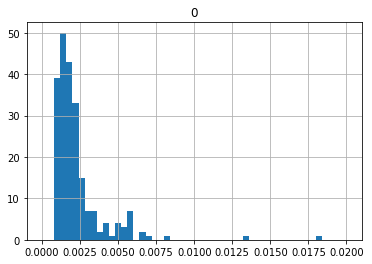

In [155]:
print(TopicTerm.objects.filter(topic=topic).aggregate(Sum('score')))
print(TopicTerm.objects.filter(topic=topic, PY=1).aggregate(Sum('score')))
print(TopicTerm.objects.filter(topic=topic, PY=1).aggregate(Count('score')))

df_termscores = pd.DataFrame.from_dict(TopicTerm.objects.filter(topic=topic, PY=1).values_list('score'))
df_termscores.hist(bins=50, range=(0, 0.02))